Creating data generators...
Found 10324 images belonging to 98 classes.
Found 2533 images belonging to 98 classes.
Number of classes detected: 98
Class indices: {'Aloevera': 0, 'Amla': 1, 'Amruta_Balli': 2, 'Amruthaballi': 3, 'Arali': 4, 'Ashoka': 5, 'Ashwagandha': 6, 'Astma_weed': 7, 'Avacado': 8, 'Badipala': 9, 'Balloon_Vine': 10, 'Bamboo': 11, 'Basale': 12, 'Beans': 13, 'Betel': 14, 'Betel_Nut': 15, 'Bhrami': 16, 'Brahmi': 17, 'Bringaraja': 18, 'Caricature': 19, 'Castor': 20, 'Catharanthus': 21, 'Chakte': 22, 'Chilly': 23, 'Citron lime (herelikai)': 24, 'Coffee': 25, 'Common rue(naagdalli)': 26, 'Coriender': 27, 'Curry': 28, 'Curry_Leaf': 29, 'Doddapatre': 30, 'Doddpathre': 31, 'Drumstick': 32, 'Ekka': 33, 'Eucalyptus': 34, 'Ganigale': 35, 'Ganike': 36, 'Gasagase': 37, 'Gauva': 38, 'Geranium': 39, 'Ginger': 40, 'Globe Amarnath': 41, 'Guava': 42, 'Henna': 43, 'Hibiscus': 44, 'Honge': 45, 'Insulin': 46, 'Jackfruit': 47, 'Jasmine': 48, 'Kambajala': 49, 'Kasambruga': 50, 'Kohlrabi': 51,

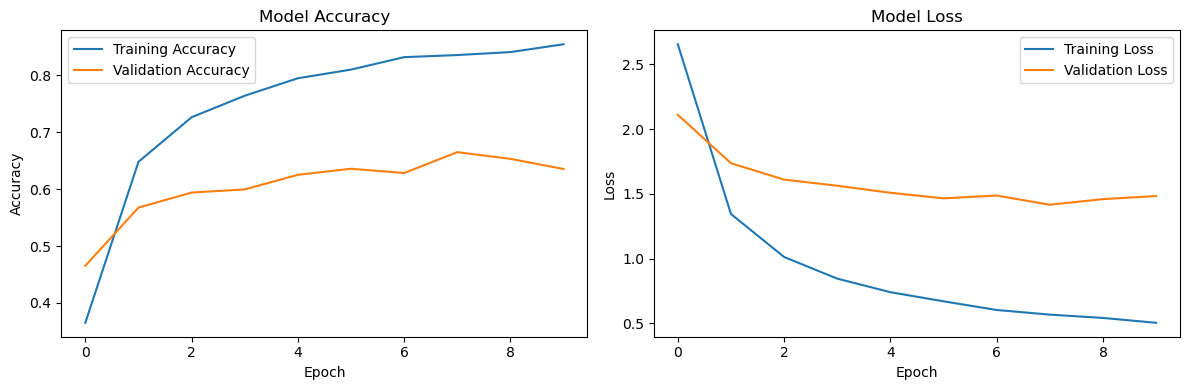

Model saved as simple_mobilenet_classifier.h5


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# --- Step 1: Define the path to your dataset ---
# Make sure your folders are structured correctly!
# Your_Main_Data_Folder/
# ├── ClassA/
# │   ├── img1.jpg
# │   └── img2.png
# ├── ClassB/
# │   ├── img3.jpg
# │   └── img4.png
# └── ClassC/
#     ├── img5.jpg
#     └── img6.png
data_dir = "combined"

# Helper function to count the number of classes automatically
def get_num_classes(data_dir):
    """Counts the number of subdirectories (classes) in a given directory."""
    return len([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

if __name__ == "__main__":
    if not os.path.exists(data_dir):
        print(f"Error: The directory '{data_dir}' does not exist.")
        print("Please ensure your dataset is in the correct location and structure.")
    else:
        num_classes = get_num_classes(data_dir)
        if num_classes == 0:
            print("Error: No class folders found in the data directory. Cannot proceed.")
        else:
            # --- Step 2: Create Data Generators with Augmentation and Splitting ---
            print("Creating data generators...")
            train_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.2, # 20% of data for validation
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            train_generator = train_datagen.flow_from_directory(
                data_dir,
                target_size=(224, 224),
                batch_size=32,
                class_mode='categorical',
                subset='training',
                shuffle=True
            )

            val_generator = train_datagen.flow_from_directory(
                data_dir,
                target_size=(224, 224),
                batch_size=32,
                class_mode='categorical',
                subset='validation',
                shuffle=False
            )
            
            print(f"Number of classes detected: {num_classes}")
            print(f"Class indices: {train_generator.class_indices}")

            # --- Step 3: Build the Simple Model ---
            print("Building the model...")
            # Load the pre-trained MobileNetV2 model without the top classification layer
            base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
            )

            # Freeze the layers of the base model
            base_model.trainable = False

            # Add your custom classification head on top of the base model
            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            x = Dropout(0.2)(x) # A simple dropout layer
            predictions = Dense(num_classes, activation='softmax')(x)

            model = Model(inputs=base_model.input, outputs=predictions)

            # --- Step 4: Compile the Model ---
            print("Compiling the model...")
            model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # --- Step 5: Train the Model ---
            print("Starting training...")
            early_stopping = EarlyStopping(
                monitor='val_loss', # Stop when validation loss stops improving
                patience=5,
                restore_best_weights=True
            )

            history = model.fit(
                train_generator,
                epochs=10,
                validation_data=val_generator,
                callbacks=[early_stopping],
                verbose=1
            )
            
            # --- Step 6: Plot Training History ---
            def plot_training_history(history):
                """Plots training and validation accuracy and loss."""
                history_dict = history.history
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                ax1.plot(history_dict['accuracy'], label='Training Accuracy')
                ax1.plot(history_dict['val_accuracy'], label='Validation Accuracy')
                ax1.set_title('Model Accuracy')
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Accuracy')
                ax1.legend()
                
                ax2.plot(history_dict['loss'], label='Training Loss')
                ax2.plot(history_dict['val_loss'], label='Validation Loss')
                ax2.set_title('Model Loss')
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Loss')
                ax2.legend()
                
                plt.tight_layout()
                plt.show()

            plot_training_history(history)

            # --- Step 7: Save the Model ---
            model.save("simple_mobilenet_classifier1.h5")
            print("Model saved as simple_mobilenet_classifier.h5")

            # --- Step 8: Example of Making a Prediction ---
            def predict_image(model, img_path, class_indices):
                """Predict the class of a single image."""
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Rescale
                
                predictions = model.predict(img_array)
                predicted_class_idx = np.argmax(predictions[0])
                predicted_prob = predictions[0][predicted_class_idx]
                
                class_names = {v: k for k, v in class_indices.items()}
                predicted_class = class_names[predicted_class_idx]
                
                return predicted_class, predicted_prob

            # Example usage of the prediction function
            # test_image_path = "path/to/a/new/image.jpg"
            # predicted_class, confidence = predict_image(
            #     model,
            #     test_image_path,
            #     train_generator.class_indices
            # )
            # print(f"Predicted class: {predicted_class} (Confidence: {confidence:.2f})")
